<a href="https://colab.research.google.com/github/xbadiam/Energy_consumption_steel_industry/blob/main/notebooks/Energy_consumption_steel_industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy consumption of the steel industry

## 1. Context

This company produces several types of coils, steel plates, and iron plates. The information on electricity consumption is held in a cloud-based system. The information on energy consumption of the industry is stored on the website of the Korea Electric Power Corporation (pccs.kepco.go.kr), and the perspectives on daily, monthly, and annual data are calculated and shown.

### 1.1. Attribute Information:

* Date Continuous-time data taken on the first of the month
* Usage_kWh Industry Energy Consumption Continuous kWh
* Lagging Current reactive power Continuous kVarh
* Leading Current reactive power Continuous kVarh
* CO2 Continuous ppm
* NSM Number of Seconds from midnight Continuous S
* Week status Categorical (Weekend (0) or a Weekday(1))
* Day of week Categorical Sunday, Monday : Saturday
* Load Type Categorical Light Load, Medium Load, Maximum Load

### 1.2. Acknowledgements

This dataset is sourced from the UCI Machine Learning Repository

### 1.3. Inspiration
Which times of the year is the most energy consumed?
What patterns can we identify in energy usage?

## 2. Imports

In [77]:
!rm -rf /content/Energy_consumption_steel_industry

! git clone https://github.com/xbadiam/Energy_consumption_steel_industry.git

Cloning into 'Energy_consumption_steel_industry'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 132 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 1.32 MiB | 3.72 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [78]:
try:
  import skforecast
except:
  !pip install skforecast
  import skforecast

In [79]:
# Data processing
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# graphic
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelado y Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
import skforecast
from skforecast.plot import calculate_lag_autocorrelation, plot_residuals
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from statsmodels.tsa.stattools import kpss, adfuller

## 2. Funtions


In [101]:
# Function to run ADF Test and print results
def adf_test(series):
  ADF_result = adfuller(series)
  print(f'p-value: {ADF_result[1]}')
  if ADF_result[1] < 0.05:
    print(f'ADF Statistic: {ADF_result[0]}')
    print("The time series is stationary (we Reject the null hypothesis H0).")
  else:
    print("The time series is non-stationary (we cannot reject the null hypothesis H0).")
  print('\n')

def kpss_test(series):
  KPSS_result = kpss(series, regression='c', nlags="auto")
  print(f'p-value: {KPSS_result[1]}')
  if KPSS_result[1] < 0.05:
    print("The time series is not stationary (Reject H0).")
  else:
    print("The time series is stationary (Fail to reject H0).")
  print('\n')


## 3. Load data

In [81]:
data = pd.read_csv('/content/Energy_consumption_steel_industry/inputs/Steel_industry_data.csv')


In [82]:
data.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


In [83]:
# Dataset information
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [84]:
# Statistical summary
print('Statistical Summary of Numerical Features:')
print('-' * 50)
data.describe().T

Statistical Summary of Numerical Features:
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Usage_kWh,35040.0,27.386892,33.444380,0.0,3.20,4.57,51.2375,157.18
Lagging_Current_Reactive.Power_kVarh,35040.0,13.035384,16.306000,0.0,2.30,5.00,22.6400,96.91
Leading_Current_Reactive_Power_kVarh,35040.0,3.870949,7.424463,0.0,0.00,0.00,2.0900,27.76
CO2(tCO2),35040.0,0.011524,0.016151,0.0,0.00,0.00,0.0200,0.07
Lagging_Current_Power_Factor,35040.0,80.578056,18.921322,0.0,63.32,87.96,99.0225,100.00
Leading_Current_Power_Factor,35040.0,84.367870,30.456535,0.0,99.70,100.00,100.0000,100.00
NSM,35040.0,42750.000000,24940.534317,0.0,21375.00,42750.00,64125.0000,85500.00


In [85]:
# Preprocesado de datos (estableciendo índice y frecuencia)
# ==============================================================================

data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')
data = data.set_index('date')
data = data.asfreq('15min')
data = data.sort_index()

In [86]:
start_date = data.index.min()
end_date = data.index.max()
date_range_complete = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)

# Detectar si faltan fechas
missing_dates = date_range_complete.difference(data.index)

print(f"Complete index: {len(missing_dates) == 0}")
print(f"Missing dates: {len(missing_dates)}")
print(f"Rows with missing values: {data.isnull().any(axis=1).mean():.2%}")

Complete index: True
Missing dates: 0
Rows with missing values: 0.00%


In [87]:
# Extract temporal features from date
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data['day_of_year'] = data.index.dayofyear
data['week_of_year'] = data.index.isocalendar().week
data['quarter'] = data.index.quarter

## 4. Data division

the dataset starts on 2018-01-01 00:00:00 and ends on 2018-12-31 23:45:00. In addition, to optimize the model's hyperparameters and evaluate its predictive performance, the data is divided into three sets: training, validation and test.

In [88]:
# 9. Dividir tren / test
split = int(len(data)*0.8)
data_train = data.iloc[:split]
data_test = data.iloc[split:]

In [89]:
print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
#print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Fechas train      : 2018-01-01 00:00:00 --- 2018-10-19 23:45:00  (n=28032)
Fechas test       : 2018-10-20 00:00:00 --- 2018-12-31 23:45:00  (n=7008)


## 5. Graphic exploration

### 5.1. Time series chart

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Usage_kWh'], mode='lines', name='Train'))
#fig.add_trace(go.Scatter(x=data_val.index, y=datos_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Usage_kWh'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Actual Usage (kWh)',
    xaxis_title="Date",
    yaxis_title="Usage (MWh)",
    legend_title="Particion:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
fig.show()

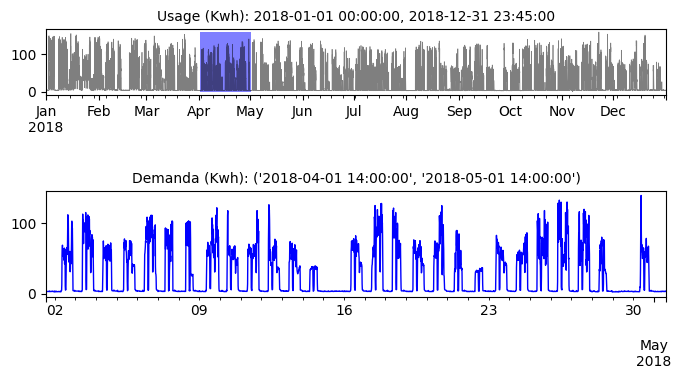

In [91]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2018-04-01 14:00:00','2018-05-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data['Usage_kWh'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data['Usage_kWh'])
max_y = max(data['Usage_kWh'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]]['Usage_kWh'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Usage (Kwh): {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Demanda (Kwh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

When zooming in on the time series, a clear weekly seasonality becomes evident, with higher consumption during weekdays (Monday to Friday) and lower or nothing consumption on weeknends. It is also observed that there is a strong correlation between the consumption of one day and that of the previous day.  

### 5.2. Stationarity chart

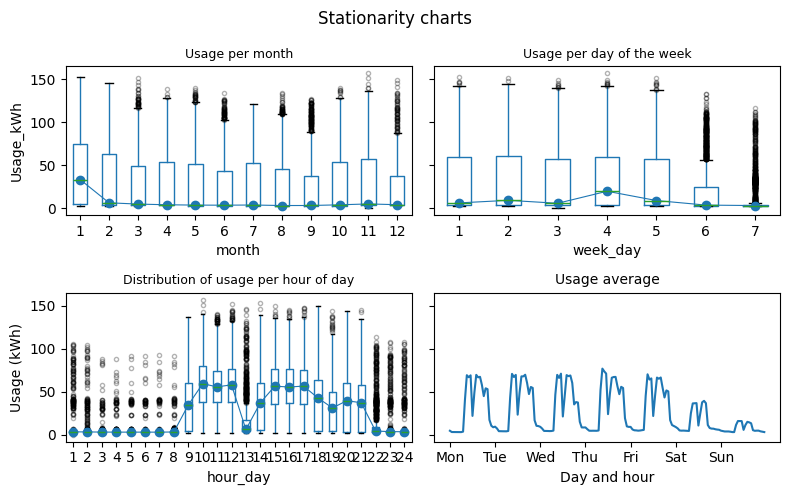

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribution of usage per month
data['month'] = data.index.month
data.boxplot(column='Usage_kWh', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['Usage_kWh'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Usage_kWh')
axs[0].set_title('Usage per month', fontsize=9)

# Distribution of usage per day of week
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Usage_kWh', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['Usage_kWh'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Usage (kWh)')
axs[1].set_title('Usage per day of the week', fontsize=9)

# Distribution of usage per hour of day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Usage_kWh', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['Usage_kWh'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Usage (kWh)')
axs[2].set_title('Distribution of usage per hour of day', fontsize=9)

# Distribusión de demanda por día de la semana y hora del día
mean_day_hour = data.groupby(["week_day", "hour_day"])["Usage_kWh"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Usage average",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Usage"
)

axs[3].title.set_size(10)

fig.suptitle("Stationarity charts", fontsize=12)
fig.tight_layout()

**Augmented Dickey-Fuller (ADF)**

The first step is to determine whether our random walk is stationary or not. We
know that since there are visible trends in our sequence, it is not stationary. Nevertheless, let’s apply the ADF test to make sure.

* If $p−valor <α$ ⇒ It is rejected ${H_0}$
* If $p−valor ≥ α$ ⇒ It is accepted ${H_0}$

In [102]:
# Run ADF test on original data
adf_test(data['Usage_kWh'])

p-value: 0.0
ADF Statistic: -24.298021505953816
The time series is stationary (we Reject the null hypothesis H0).




**KPSS Test**

It is an useful tool in the time series analysis toolbox for determining whether stationarity exists in a given data set is the KPSS test. The KPSS test determines if the data behaves consistently by comparing the alternative of a unit root process to the null hypothesis of trend-stationarity.

The null hypothesis for the KPSS test is that the data are stationary. For this test, we do NOT want to reject the null hypothesis. In other words, we want the p-value to be greater than 0.05 not less than 0.05.

In [94]:
kpss_test(data['Usage_kWh'])

p-value: 0.01
The time series is not stationary (Reject H0).




/tmp/ipython-input-4202268114.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The p-value is greater than 0.05. The null hypothesis of stationarity around a trend is not rejected.

### 5.3. Autocorrelation graphs

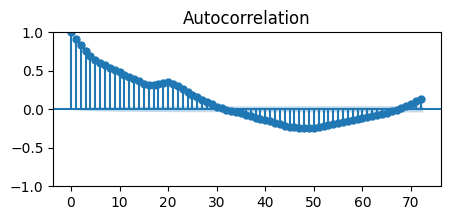

In [95]:
# Autocorrelation graph
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['Usage_kWh'], ax=ax, lags=72)
plt.show()

We notice how the autocorrelation coefficients slowly decrease as the lag increases, which is a clear indicator that our random walk is not a stationary process.

In [97]:
diff_random_walk = np.diff(data['Usage_kWh'], n=1)

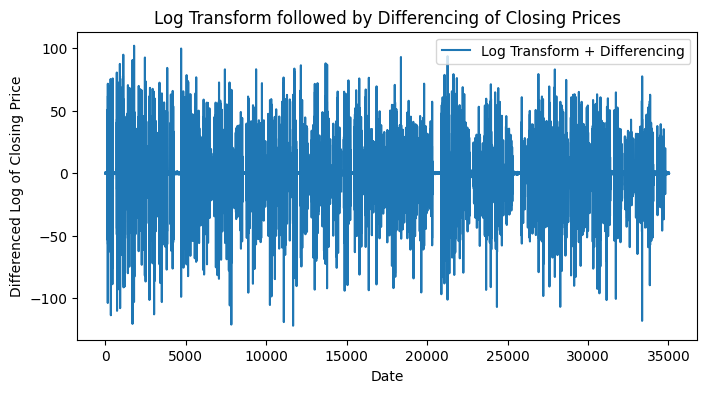

In [106]:
plt.figure(figsize=(8, 4))
plt.plot(diff_random_walk, label='Log Transform + Differencing')
plt.title(f'Log Transform followed by Differencing of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Log of Closing Price')
plt.legend()
plt.show()

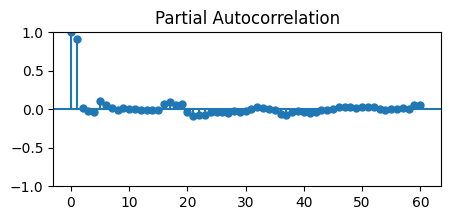

In [96]:
# Partial autocorrelation graph
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['Usage_kWh'], ax=ax, lags=60)
plt.show()

We can visualize the differenced simulated random walk. we have removed the trend from our series. Furthermore, the variance looks quite stable. Let’s test for stationarity again, using the ADF test

In [103]:
adf_test(diff_random_walk)

p-value: 0.0
ADF Statistic: -40.90079545369076
The time series is stationary (we Reject the null hypothesis H0).




This prints out an ADF statistic of –31.79 with a p-value of 0. This time the ADF statistic is a large negative number, and the p-value is less than 0.05. Therefore, we reject the null hypothesis, and we can say that this process has no unit root and is stationary.



In [99]:
# Top 10 lags con mayor autocorrelación parcial absoluta
# ==============================================================================
calculate_lag_autocorrelation(
    data    = data['Usage_kWh'],
    n_lags  = 60,
    sort_by = "partial_autocorrelation_abs"
).head(10)

,lag,partial_autocorrelation_abs,partial_autocorrelation,autocorrelation_abs,autocorrelation
0,1,0.911559,0.911559,0.911533,0.911533
1,5,0.112307,0.112307,0.639161,0.639161
2,17,0.099577,0.099577,0.321087,0.321087
3,21,0.084499,-0.084499,0.334065,0.334065
4,37,0.071151,-0.071151,0.092975,-0.092975
5,22,0.069954,-0.069954,0.305830,0.305830
6,23,0.068908,-0.068908,0.266639,0.266639
7,16,0.068189,0.068189,0.318953,0.318953
8,19,0.066287,0.066287,0.345448,0.345448
9,6,0.059981,0.059981,0.603707,0.603707


## 6. Modelo Baseline

In [ ]:
# Create a baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Forescater's training
# ==============================================================================
end_train = str(data_train.index[-1])
forecaster.fit(y=data.loc[:end_train , 'Usage_kWh'])
forecaster

In [ ]:
# Backtesting
# ==============================================================================
end_test = str(data_test.index[-1])

cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_train]),
        refit              = False
)
metrica, predicciones = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['Usage_kWh'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                       )
metrica

## 7. Recursive autoregressive model

It's training a recursive autoregressive model

In [ ]:
# Create the forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                 lags            = 24,
                 window_features = window_features
             )

# Entrena el forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'Usage_kWh'])
forecaster

### 7.1. Backtesting

In [ ]:
# Backtesting
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data['Usage_kWh'],
                            cv         = cv,
                            metric     = 'mean_absolute_error',
                            verbose    = True,  # False para no mostrar info
                        )

In [ ]:
# Error backtest
# ==============================================================================
metrica

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)